<a href="https://colab.research.google.com/github/patricksabry1/42028-Deep-Learning/blob/master/Assessment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Image classification - 17 Flowers dataset

The baseline architecture used will be the vgg16 architecture. The original vgg16 architecture will be experimented with first, and then transfer learning will be used to adapt the pre-trained vgg16 model to the flower data. The results of both models will be evaluated and compared for accuracy and training time.


## Data pre-processing

### Initialise dependencies & mount g drive for data extraction

In [2]:
%pip install livelossplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKerasTF
from tqdm import tqdm
from skimage import feature
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
import cv2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/

/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2


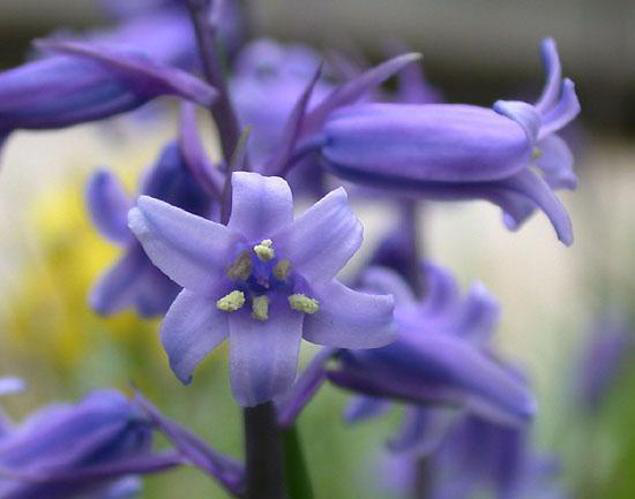

In [4]:
from PIL import Image #show one example of image
Image.open("../assignment-2/17FlowerDataset/Bluebell/image_0241.jpg")

In [0]:
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 299x299 for InceptionNet compatibility
    img = np.asarray(img, dtype='float32')

    return img

In [0]:
import os

# Load images as np arrays to be saved again as images later on when split into train and test subsets.
rootdir = '../assignment-2/17FlowerDataset/'
images=[]
labels=[]
total=1361
j=1
i=0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        images.append(load_data(os.path.join(subdir, file)))
        labels.append(j) #labels are created as well
        i += 1
        if i % 80 == 0: j += 1

## Class keys
{1: 'Cowslip', 2: 'Crocus', 3: 'Buttercup', 4: 'Dandelion', 5: 'Daffodil', 6: 'Iris', 7: 'Daisy', 8: 'ColtsFoot', 9: 'Bluebell', 10: 'Fritillary', 11: 'Tigerlily', 12: 'LilyValley', 13: 'Pansy', 14: 'Snowdrop', 15: 'Windflower', 16: 'Tulip', 17: 'Sunflower'}

In [10]:
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

(1360, 224, 224, 3)

In [0]:
# Split data into training and test. Since this is a very small dataset, a 85/15 split was deemed best to avoid overfitting.
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=104)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


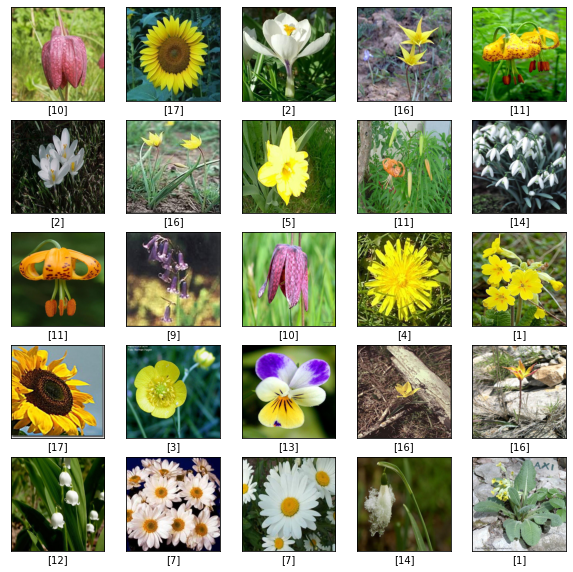

In [12]:
# plot some sample images with corresponding labels to verify image labelling.
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i]/255, cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [13]:
# dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np
def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname): #check if the folder exists; if not make dir
      os.mkdir(dirname)
    n=0
    
    for i in data:
      label_n=labels[n]
      subfolder = folder + "/" + str(label_n) 
      if not os.path.exists(subfolder): # create subfolders with categories
          os.mkdir(subfolder)  
      filepath =  subfolder + "/" + str(n)+ ".jpg"
      cv2.imwrite(filepath, data[n]) #save image to corresponding subfolders
      n+=1

create_images(X_train, y_train, 'train') #save image to corresponding subfolders
create_images(X_test, y_test, 'test')
create_images(X_val, y_val, 'validation')


KeyboardInterrupt: ignored

## Image data augmentation


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir =os.path.realpath('train')
validation_dir = os.path.realpath('test')
image_size = 224

train_datagen = ImageDataGenerator(
      rescale=1./255,
      horizontal_flip=True,
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      fill_mode='nearest'
      )
 
test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 32
val_batchsize = 10
 
# Fit the train and test images onto the data generators to augment them.
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
test_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 2769 images belonging to 17 classes.
Found 409 images belonging to 17 classes.


## VGG16 implementation for 17Flowers image classification

The VGG16 model initialised with ImageNet weights will be used as a pre-trained model to conduct transfer learning on the 17Flowers dataset. The fully connected layer will not be included and substituted with our own fully connected layer to increase adaptability of the model.

### Baseline model

In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers,optimizers
from keras.preprocessing import image
import tensorflow.keras.applications.vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.layers import Input, Dense

# Load the model initialised with ImageNet weights
vgg_transfer = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
vgg_transfer.summary()

# Use conv layers only for feature extraction
for layer in vgg_transfer.layers[:-4]:
    layer.trainable = False

# Initialise model architecture
model = tf.keras.models.Sequential()
model.add(vgg_transfer)

# Add fully connected layers and final output layer
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
model.summary() 


# Plot model exports model visualisation to PNG
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=2e-4), metrics=['acc'])

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [0]:
# LR schedule - reduce learning rate on loss plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)

callbacks = [reduce_lr, tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]

history = model.fit(
      train_generator,
      shuffle=True,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=test_generator,
      validation_steps=test_generator.samples/test_generator.batch_size,
      callbacks=callbacks,
      verbose=1)


print('training acc.:', history.history['acc'][-1], '\n','test acc.:', (history.history['val_acc'])[-1])

Epoch 1/50
51/86 [================>.............] - ETA: 6:48 - loss: 2.8901 - acc: 0.0680

Model results (scratchpad):

VGG16: single FC layer 1024, 0.5 dropout
- RMSProp, train batch_size:100, val batch_size:10 - train acc:99.16% test acc: 91.20%
- RMSProp, train batch_size:64, val batch_size:64 - train acc: 93.90% test acc: 89.73%

VGG16: two FC layers 1024 , 0.5 dropout
- RMSProp, train batch size:32, val batch size:10 - train acc: 99.27% test acc: 94.38%
InceptionV3:
- RMSProp, train batch size: 32, val batch size: 10 - train acc: 88.16% test acc: 44.1%

In [1]:
# plot accuracy hisory
import matplotlib.pyplot as plt
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy %')
 plt.plot(history.epoch, np.array(history.history['acc']),
 label='Train Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_acc']),
 label = 'Val Accuracy')
 plt.legend()
 plt.ylim([0.5, 1])
plot_history(history)



NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Custom Object Detection

## Faster-RCNN implementation


In [0]:
import os
import sys
import re

%tensorflow_version 1.x
!pip install numpy==1.17.4

# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/Tony607/object_detection_demo'

# Number of training steps.
num_steps = 1000 

# Number of evaluation steps.
num_eval_steps = 50  

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 8
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# fast-RCNN model selected from config
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file to be used in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size (could be bigger however restricted by single P100 Tesla GPU on Colab instance)
batch_size = MODELS_CONFIG[selected_model]['batch_size']

TensorFlow 1.x selected.


In [0]:
%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
fatal: destination path 'object_detection_demo' already exists and is not an empty directory.
/content/object_detection_demo
Already up to date.


In [0]:
%cd /content

#!git clone --quiet https://github.com/tensorflow/models.git

!git clone --branch r1.13.0 --depth 1 https://github.com/tensorflow/models.git

!pip install tf-slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [0]:
%cd {repo_dir_path}

# Create train data:
!python xml_to_csv.py -i "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-train" -o "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/train_labels.csv" -l "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations"

# Create test data:
!python xml_to_csv.py -i "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-test" -o "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/test_labels.csv" -l "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations"


/content/object_detection_demo
Successfully converted xml to csv.
Generate `/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt`
Successfully converted xml to csv.
Generate `/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt`


In [0]:
# Generate train tfrecord
!python generate_tfrecord.py --csv_input="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train_labels.csv" --output_path="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train.record" --img_path="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-train" --label_map "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt"

# Generate test tfrecord
!python generate_tfrecord.py --csv_input="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test_labels.csv" --output_path="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test.record" --img_path="/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-test" --label_map "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt"



W0604 06:18:37.408426 140162681202560 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0604 06:18:37.512961 140162681202560 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train.record


W0604 06:18:42.254721 140093502179200 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0604 06:18:42.281426 140093502179200 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test.record


In [0]:
train_record_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train.record"
test_record_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test.record"
label_map_pbtxt_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt"

In [0]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 65 root   root 4.0K Jun  4 06:18 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [0]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

In [0]:
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [0]:
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [0]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [0]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-06-04 06:19:43--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.232.237.110, 52.71.209.190, 54.85.41.146, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.232.237.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.5’

ngrok-stable-linux- 100%[===================>]  13.13M  11.9MB/s    in 1.1s    

2020-06-04 06:19:44 (11.9 MB/s) - ‘ngrok-stable-linux-amd64.zip.5’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://0b157fff136d.ngrok.io


In [0]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0604 06:21:29.499211 139778040678272 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 200
I0604 06:21:29.499437 139778040678272 config_util.py:523] Maybe overwriting train_steps: 200
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0604 06:21:29.499546 139778040678272 config_util.py:523] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0604 06:21:29.499621 139778040678272 config_util.py:523] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0604 06:21:29.499698 139778040678272 config_util.py:523] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0604 06:21:29.499768 139778040678272 config_util.py:523] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0604 06:21:29.499837 139778040678272 config_util.py:533

In [0]:
!ls {model_dir}

checkpoint				     model.ckpt-0.index
eval_0					     model.ckpt-0.meta
events.out.tfevents.1591251723.42b6631f756e  model.ckpt-200.data-00000-of-00001
export					     model.ckpt-200.index
graph.pbtxt				     model.ckpt-200.meta
model.ckpt-0.data-00000-of-00001


### Export trained inference graph to reproduce results

In [0]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-200
Instructions for updating:
Please use `layer.__call__` method instead.
W0604 06:25:06.173062 140168191408000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0604 06:25:07.473426 140168191408000 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0604 06:25:07.485766 140168191408000 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0604 06:25:07.486102 140168191408000 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0604 06:25:07.534322 1

In [0]:
import os
import glob

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

## Use frozen detection graph to visualize model performance

/content/models/research/object_detection


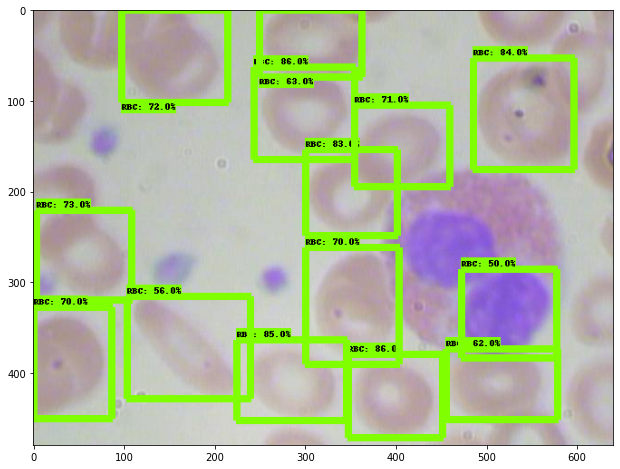

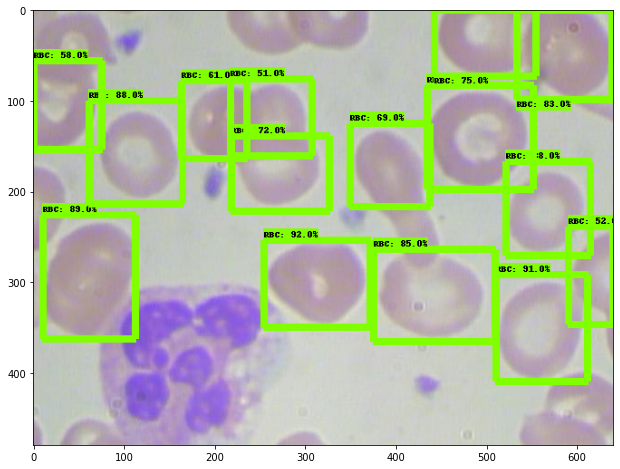

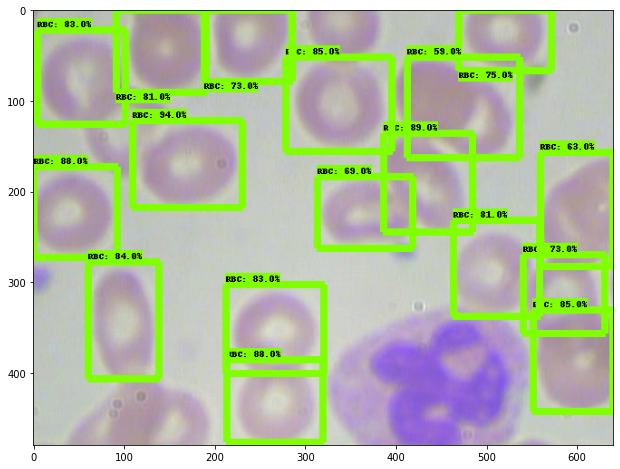

In [0]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Single Shot Detector Implementation

In [0]:
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [0]:
train_record_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/train.record"
test_record_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/test.record"
label_map_pbtxt_fname = "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-annotations/annotations/label_map.pbtxt"

In [0]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
num_classes = get_num_classes(label_map_pbtxt_fname)

with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [0]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')


In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://0b157fff136d.ngrok.io


In [0]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps=2000 \
    --num_eval_steps=50

W0604 07:37:27.823657 140083152521088 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0604 07:37:27.823921 140083152521088 config_util.py:523] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0604 07:37:27.824040 140083152521088 config_util.py:523] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0604 07:37:27.824117 140083152521088 config_util.py:523] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0604 07:37:27.824208 140083152521088 config_util.py:523] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0604 07:37:27.824284 140083152521088 config_util.py:523] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0604 07:37:27.824352 140083152521088 config_util.py:5

In [0]:
import re
import numpy as np

output_directory = './fine_tuned_model/ssd'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-2000
Instructions for updating:
Please use `layer.__call__` method instead.
W0604 07:49:16.691288 139891612026752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0604 07:49:18.673469 139891612026752 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0604 07:49:18.708982 139891612026752 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0604 07:49:18.839357 139891612026752 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:dept

In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  "/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation/BloodImage_00410.jpeg', '/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation/BloodImage_00409.jpeg', '/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/blood-validation/BloodImage_00408.jpeg']


/content/models/research/object_detection


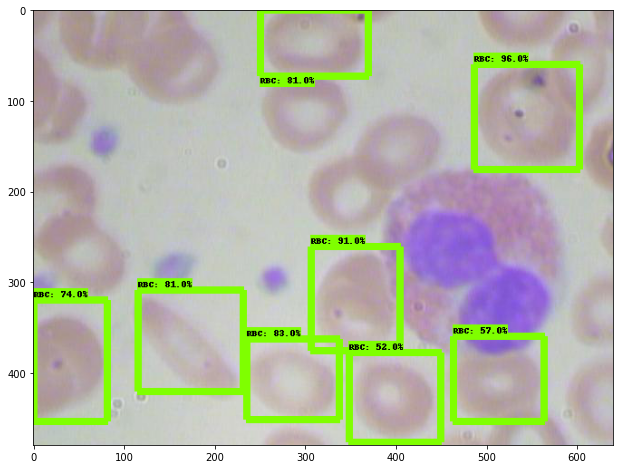

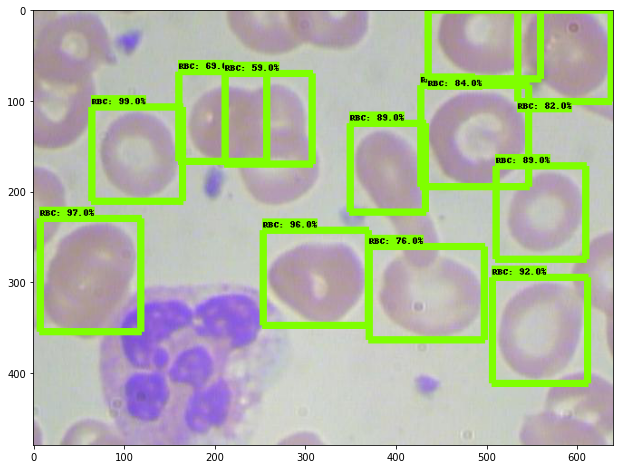

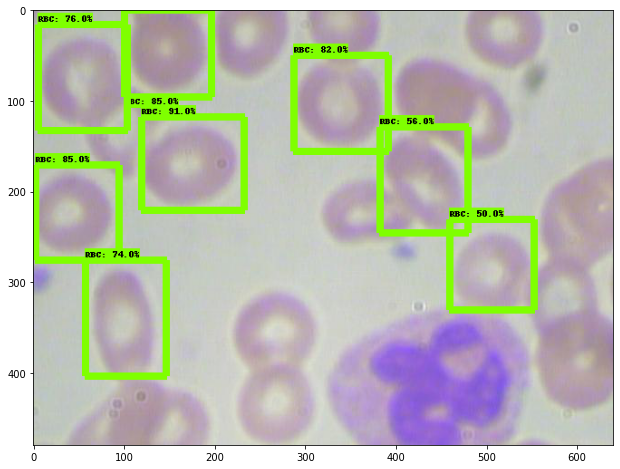

In [0]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)